In [280]:
from pyspark.sql import SparkSession

In [281]:
spark = SparkSession.builder.getOrCreate()

In [282]:
# Load in users and user engagement csv's
data_path = '/Users/natha/Desktop/bootcamp_repo-1/relax_challenge/'
file_path_1 = data_path + '/takehome_users.csv'
file_path_2 = data_path + '/takehome_user_engagement.csv'

df1 = spark.read.format("csv").option("header", "true").load(file_path_1)
df2 = spark.read.format("csv").option("header", "true").load(file_path_2)

In [283]:
df2.createOrReplaceTempView('engagement')

In [284]:
# Set a new column for 2 visits ahead of current, known that each visit is a distinct date and is in order of occurence.
sql_window = 'SELECT time_stamp, user_id,  \
         lead(time_stamp, 2) OVER (PARTITION BY user_id ORDER BY user_id) time_stamp_lead_2 \
         FROM engagement'

spark.sql(sql_window).createOrReplaceTempView('engagement_lead_2')
spark.sql(sql_window).show(5)

+-------------------+-------+-------------------+
|         time_stamp|user_id|  time_stamp_lead_2|
+-------------------+-------+-------------------+
|2014-04-22 03:53:30|      1|               null|
|2013-01-16 22:08:03|     10|2013-01-30 22:08:03|
|2013-01-22 22:08:03|     10|2013-02-04 22:08:03|
|2013-01-30 22:08:03|     10|2013-02-06 22:08:03|
|2013-02-04 22:08:03|     10|2013-02-14 22:08:03|
+-------------------+-------+-------------------+
only showing top 5 rows



In [285]:
# Make a comparison of current visit and 2 visits ahead for days apart, set a new column.
sql_window = 'SELECT user_id, time_stamp, time_stamp_lead_2, DATEDIFF(time_stamp_lead_2, time_stamp) days_apart\
           FROM engagement_lead_2'

spark.sql(sql_window).createOrReplaceTempView('engagement_days_apart')
spark.sql(sql_window).show(5)

+-------+-------------------+-------------------+----------+
|user_id|         time_stamp|  time_stamp_lead_2|days_apart|
+-------+-------------------+-------------------+----------+
|      1|2014-04-22 03:53:30|               null|      null|
|     10|2013-01-16 22:08:03|2013-01-30 22:08:03|        14|
|     10|2013-01-22 22:08:03|2013-02-04 22:08:03|        13|
|     10|2013-01-30 22:08:03|2013-02-06 22:08:03|         7|
|     10|2013-02-04 22:08:03|2013-02-14 22:08:03|        10|
+-------+-------------------+-------------------+----------+
only showing top 5 rows



In [286]:
# Group by users and find each users shortest period of 3 visits. If a user has 3 visits w/in 7 days consider as "adopted".
# Null values where there are not 3 visits, set "adopted" to false.
sql_window = 'SELECT user_id, MIN(days_apart) days_for_3_visits, IFNULL(MIN(days_apart)<=7, FALSE) adopted_user\
           FROM engagement_days_apart \
           GROUP BY user_id'

spark.sql(sql_window).createOrReplaceTempView('engagement_adopted_users')
spark.sql(sql_window).show(5)

+-------+-----------------+------------+
|user_id|days_for_3_visits|adopted_user|
+-------+-----------------+------------+
|      1|             null|       false|
|     10|                2|        true|
|    100|             null|       false|
|  10000|             null|       false|
|  10002|                3|        true|
+-------+-----------------+------------+
only showing top 5 rows



In [287]:
# Show counts of adopted/unadopted users
sql_window = 'SELECT adopted_user, count(*)\
           FROM engagement_adopted_users \
           GROUP BY adopted_user'

spark.sql(sql_window).createOrReplaceTempView('engagement_value_counts')
spark.sql(sql_window).show(5)

+------------+--------+
|adopted_user|count(1)|
+------------+--------+
|        true|    1656|
|       false|    7167|
+------------+--------+



In [288]:
# Bring in users data.
df1.createOrReplaceTempView('users')

In [289]:
# Left join user data to determined adopted/unadopted list.
sql_window = 'SELECT u.object_id, u.creation_time, u.name, u.email, u.creation_source, \
           u.last_session_creation_time, u.opted_in_to_mailing_list, \
           u.enabled_for_marketing_drip, u.org_id, u.invited_by_user_id, \
           e.adopted_user \
           FROM users u \
           LEFT JOIN engagement_adopted_users e \
           ON e.user_id = u.object_id'

spark.sql(sql_window).createOrReplaceTempView('users_join')
spark.sql(sql_window).show(5)

+---------+-------------------+-----------------+--------------------+---------------+--------------------------+------------------------+--------------------------+------+------------------+------------+
|object_id|      creation_time|             name|               email|creation_source|last_session_creation_time|opted_in_to_mailing_list|enabled_for_marketing_drip|org_id|invited_by_user_id|adopted_user|
+---------+-------------------+-----------------+--------------------+---------------+--------------------------+------------------------+--------------------------+------+------------------+------------+
|        1|2014-04-22 03:53:30|   Clausen August|AugustCClausen@ya...|   GUEST_INVITE|                1398138810|                       1|                         0|    11|             10803|       false|
|        2|2013-11-15 03:45:04|    Poole Matthew|MatthewPoole@gust...|     ORG_INVITE|                1396237504|                       0|                         0|     1|        

In [290]:
# Nulls (where users were not present) in engagement log, set to unadopted (FALSE).
sql_window = 'SELECT object_id, creation_time, name, email, creation_source, \
           last_session_creation_time, opted_in_to_mailing_list, \
           enabled_for_marketing_drip, org_id, invited_by_user_id, \
           IFNULL(adopted_user, FALSE) adopted_user\
           FROM users_join'

spark.sql(sql_window).createOrReplaceTempView('users_join_2')
spark.sql(sql_window).show(5)

+---------+-------------------+-----------------+--------------------+---------------+--------------------------+------------------------+--------------------------+------+------------------+------------+
|object_id|      creation_time|             name|               email|creation_source|last_session_creation_time|opted_in_to_mailing_list|enabled_for_marketing_drip|org_id|invited_by_user_id|adopted_user|
+---------+-------------------+-----------------+--------------------+---------------+--------------------------+------------------------+--------------------------+------+------------------+------------+
|        1|2014-04-22 03:53:30|   Clausen August|AugustCClausen@ya...|   GUEST_INVITE|                1398138810|                       1|                         0|    11|             10803|       false|
|        2|2013-11-15 03:45:04|    Poole Matthew|MatthewPoole@gust...|     ORG_INVITE|                1396237504|                       0|                         0|     1|        

In [291]:
# Show counts of adopted/unadopted users
sql_window = 'SELECT adopted_user, count(*)\
           FROM users_join_2 \
           GROUP BY adopted_user'

spark.sql(sql_window).createOrReplaceTempView('users_value_counts')
spark.sql(sql_window).show(5)

+------------+--------+
|adopted_user|count(1)|
+------------+--------+
|        true|    1656|
|       false|   10344|
+------------+--------+



In [292]:
df_new = spark.sql('SELECT * FROM users_join_2')
df_new.printSchema()

root
 |-- object_id: string (nullable = true)
 |-- creation_time: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- creation_source: string (nullable = true)
 |-- last_session_creation_time: string (nullable = true)
 |-- opted_in_to_mailing_list: string (nullable = true)
 |-- enabled_for_marketing_drip: string (nullable = true)
 |-- org_id: string (nullable = true)
 |-- invited_by_user_id: string (nullable = true)
 |-- adopted_user: boolean (nullable = false)



In [293]:
import pandas as pd
labeled_data = df_new.select('*').toPandas()
labeled_data.to_csv('labeled_data.csv')

In [428]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Feature Engineering for adopted_user classification model:
# 'object_id' is user_id unused as a feature                        DONE
# 'creation_time' is datetime, convert to unix and min/max scale    DONE
# 'name' unused as a feature                                        DONE
# 'email' extract domain, target encode after split                 DONE
# 'creation_source' has 5 categories, target encode after split     DONE
# 'last_session_creation_time' is in unix, min/max scale            DONE
# 'opted_in_to_mailing_list' is 0/1 leave as is                     DONE
# 'enabled_for_marketing_drip' is 0/1 leave as is                   DONE
# 'org_id' 417 orgs, target encode after split                      DONE
# 'invited_by_user_id' see if inviter is adopted_user or not        DONE
# 'adopted_user' target T/F, convert to 0/1                         DONE

labeled_data = pd.read_csv('labeled_data.csv').drop(['Unnamed: 0'], axis=1)
labeled_data['adopted_user'] = labeled_data['adopted_user'].astype('int')

In [429]:
# https://stackoverflow.com/questions/5629907/find-email-domain-in-address-with-regular-expressions
# https://stackoverflow.com/questions/53962844/applying-regex-across-entire-column-of-a-dataframe
# Extract just the domain from each email address
import re
labeled_data['domain'] = [re.search('@[\w.]+', str(x))[0] for x in labeled_data['email']]
labeled_data['domain'].value_counts()

@gmail.com         3562
@yahoo.com         2447
@jourrapide.com    1259
@cuvox.de          1202
@gustr.com         1179
                   ... 
@lrabg.com            1
@mrytw.com            1
@ugtav.com            1
@hqhll.com            1
@iuxiw.com            1
Name: domain, Length: 1184, dtype: int64

In [430]:
# Determine with left join if the inviter of a user is an adopted user or not
labeled_data['invited_by_user_id'] = labeled_data['invited_by_user_id'].astype('Int64').fillna(0)
df_right = labeled_data[['object_id', 'adopted_user']]
labeled_data = labeled_data.merge(df_right, left_on='invited_by_user_id', right_on='object_id', 
                   how='left', suffixes=('_left', '_right'))
labeled_data.rename(columns={'object_id_left': 'object_id', 'invited_by_user_id': 'inviter_id', 
                             'adopted_user_left': 'adopted_user', 'object_id_right': 'inviter_id_dup',
                             'adopted_user_right': 'inviter_is_adopted_user'}, inplace=True)
labeled_data['inviter_is_adopted_user'] = labeled_data['inviter_is_adopted_user'].fillna(0).astype('int')

In [431]:
# New column for if user is invited or not
import numpy as np
labeled_data['invited'] = np.ceil(labeled_data['inviter_id']/max(labeled_data['inviter_id'])).astype('int')

In [432]:
import datetime
import time

# New column, account creation time as unix
labeled_data['creation_time'] = pd.to_datetime(labeled_data['creation_time'])
labeled_data['creation_time_unix'] = [time.mktime(x.timetuple()) for x in labeled_data['creation_time']]
# Impute the oldest last session unix value for NaN's (user's with no last session value)
labeled_data.last_session_creation_time.fillna(min(labeled_data.last_session_creation_time), inplace=True)

In [433]:
scaler = MinMaxScaler()
labeled_data[['creation_time_scaled', 'last_session_creation_time_scaled']] = \
    scaler.fit_transform(labeled_data[['creation_time_unix', 'last_session_creation_time']] )

In [434]:
labeled_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,inviter_id,adopted_user,domain,inviter_id_dup,inviter_is_adopted_user,invited,creation_time_unix,creation_time_scaled,last_session_creation_time_scaled
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0,@yahoo.com,10803.0,0,1,1.398164e+09,0.946796,0.938254
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1,@gustr.com,316.0,0,1,1.384516e+09,0.730397,0.908366
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,0,@gustr.com,1525.0,1,1,1.363760e+09,0.401302,0.397434
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0,@yahoo.com,5151.0,1,1,1.369149e+09,0.486746,0.483504
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0,@yahoo.com,5240.0,1,1,1.358446e+09,0.317052,0.320639


In [485]:
X = labeled_data[['domain', 'creation_source', 'org_id',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'inviter_is_adopted_user', 'invited',
       'creation_time_scaled', 'last_session_creation_time_scaled']]
y = labeled_data['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [486]:
tar_enc = ce.TargetEncoder(cols=['domain', 'creation_source', 'org_id'],
       min_samples_leaf=5, smoothing=3).fit(X_train, y_train)
X_train = tar_enc.transform(X_train)
X_test = tar_enc.transform(X_test)

In [487]:
X_train.head()

,domain,creation_source,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,inviter_is_adopted_user,invited,creation_time_scaled,last_session_creation_time_scaled
6440,0.106519,0.181818,0.058065,0,0,0,1,0.978501,0.972404
7259,0.106519,0.080429,0.148936,1,0,0,0,0.291039,0.293491
4882,0.165358,0.138889,0.230768,1,0,0,1,0.577586,0.572207
9907,0.126984,0.138889,0.095455,0,0,0,1,0.861085,0.857295
7784,0.165358,0.179487,0.133333,0,0,0,0,0.460831,0.457811


In [488]:
counter = Counter(y_train)
print('Before', counter)
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_smt)
print('After', counter)

Before Counter({0: 7220, 1: 1180})
After Counter({0: 7220, 1: 7220})


In [489]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid Search from: https://stackoverflow.com/questions/38151615/specific-cross-validation-with-random-forest
clf = RandomForestClassifier()  
param_grid = {'n_estimators': [10,30,50,70,100], 'max_depth': [None], 'max_features': [3,6,None],
    'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train_smt, y_train_smt)

print(grid_clf.best_estimator_)

RandomForestClassifier(max_features=None)


In [490]:
cv_res = pd.DataFrame(grid_clf.cv_results_)
cv_res[cv_res['rank_test_score']<=5].sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,2.776350,0.241891,0.041976,0.004129,None,None,1,100,"{'max_depth': None, 'max_features': None, 'min...",0.962604,0.987188,0.985457,0.982687,0.984072,0.980402,0.009023,1
3,1.789752,0.080278,0.039721,0.025950,None,None,1,70,"{'max_depth': None, 'max_features': None, 'min...",0.961565,0.985111,0.985457,0.983033,0.984418,0.979917,0.009213,2
2,1.351769,0.060656,0.022491,0.004913,None,None,1,50,"{'max_depth': None, 'max_features': None, 'min...",0.963296,0.983726,0.984418,0.981994,0.984072,0.979501,0.008145,3
6,0.709429,0.018237,0.013061,0.001022,None,None,2,30,"{'max_depth': None, 'max_features': None, 'min...",0.962604,0.985803,0.984765,0.980956,0.983033,0.979432,0.008573,4
1,0.811691,0.025033,0.018473,0.008588,None,None,1,30,"{'max_depth': None, 'max_features': None, 'min...",0.959834,0.984765,0.984765,0.982341,0.984072,0.979155,0.009701,5


ACCURACY:  0.9488888888888889
PRECISION:  0.7786259541984732
RECALL:  0.8571428571428571
F1:  0.8160000000000001


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

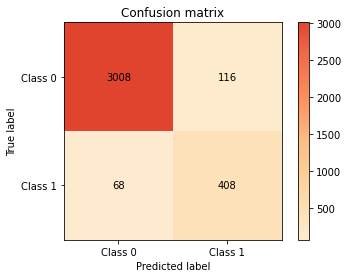

In [491]:
from sklearn_evaluation import plot
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf = RandomForestClassifier(max_depth = None, max_features=None, min_samples_leaf=1, n_estimators=100)
clf.fit(X_train_smt, y_train_smt)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation
print('ACCURACY: ', metrics.accuracy_score(y_test, y_pred))
print('PRECISION: ', metrics.precision_score(y_test, y_pred))
print('RECALL: ', metrics.recall_score(y_test, y_pred))
print('F1: ', metrics.f1_score(y_test, y_pred))
plot.confusion_matrix(y_test, y_pred)

In [492]:
print('Adopted users mean last session time scaled: ',\
    labeled_data[labeled_data['adopted_user']==1]['last_session_creation_time_scaled'].mean())
print('Unadopted users mean last session time scaled: ',\
    labeled_data[labeled_data['adopted_user']==0]['last_session_creation_time_scaled'].mean())
print('Adopted users mean creation time scaled: ',\
    labeled_data[labeled_data['adopted_user']==1]['creation_time_scaled'].mean())
print('Unadopted users mean creation time scaled: ',\
    labeled_data[labeled_data['adopted_user']==0]['creation_time_scaled'].mean())

Adopted users mean last session time scaled:  0.8923882944922542
Unadopted users mean last session time scaled:  0.4045532783777767
Adopted users mean creation time scaled:  0.4998419443792634
Unadopted users mean creation time scaled:  0.5740180644395827


Text(0, 0.5, 'Mean decrease in impurity')

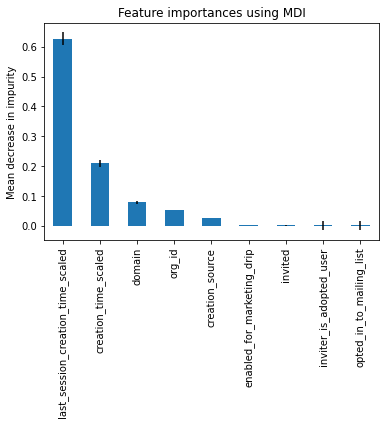

In [493]:
# feature importance
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import matplotlib.pyplot as plt
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [494]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_smt, y_train_smt)
y_pred = neigh.predict(X_test)

ACCURACY:  0.9511111111111111
PRECISION:  0.7884615384615384
RECALL:  0.8613445378151261
F1:  0.8232931726907632


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

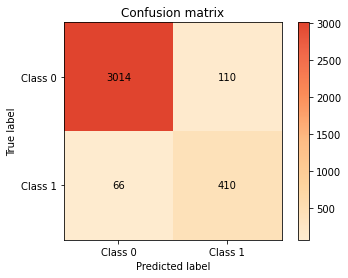

In [495]:
from sklearn_evaluation import plot
print('ACCURACY: ', metrics.accuracy_score(y_test, y_pred))
print('PRECISION: ', metrics.precision_score(y_test, y_pred))
print('RECALL: ', metrics.recall_score(y_test, y_pred))
print('F1: ', metrics.f1_score(y_test, y_pred))
plot.confusion_matrix(y_test, y_pred)